<a href="https://colab.research.google.com/github/josedavidcortes-git/usd/blob/main/FIPRODA_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Computer Science - CSC-557-U15-92793
# Dec 1, 2021
# Data Analysis, Decision Making, and Visualization
# Professor: Vijayalakshmi Saravanan
# Created By:
# Bhulakshmi Kunchala (bhulakshmi.kunchala@coyotes.usd.edu) 
# Jose David Cortes (jose.d.cortes@coyotes.usd.edu | josedavidcortes.ai@gmail.com)
# 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Power plant(Solar) Predictions part 3 of 3 

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# for plotting purposes
import seaborn as sns
import matplotlib.pyplot as plt

# options
pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings("ignore")


df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/EMHIRES_SOLAR_PVGIS_TSh_CF_n2.xlsx")


def add_date_time(_df):
    "Returns a DF with two new cols : the time and hour of the day"
    t = pd.date_range(start='1/1/1986', periods=_df.shape[0], freq = 'H')
    t = pd.DataFrame(t)
    _df = pd.concat([_df, t], axis=1)
    _df.rename(columns={ _df.columns[-1]: "time" }, inplace = True)
    _df['year'] = _df['time'].dt.year
    _df['month'] = _df['time'].dt.month
    _df['week'] = _df['time'].dt.weekofyear
    _df['day'] = _df['time'].dt.dayofyear    
    _df['hour'] = _df['time'].dt.hour
    return _df

In [ ]:
df = add_date_time(df)
df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

# keeping only values for one country(Spain ES) for the predictions
#ES30 is Madrid: https://en.wikipedia.org/wiki/NUTS_statistical_regions_of_Spain
df = df[['xx', 'year', 'month', 'week', 'day', 'hour', 'time']]
df.head(2)

,ES30,year,month,week,day,hour,time
0,0.0,1986,1,1,1,0,1986-01-01 00:00:00
1,0.0,1986,1,1,1,1,1986-01-01 01:00:00


In [ ]:
df.shape

(201480, 7)

In [ ]:
# train data including 10 years of records except the last month
train_data = df[-24*365*10:-24*31]

# test data = last month of records for year 2015
test_data = df[-24*31:]

In [ ]:
from sklearn.metrics import mean_squared_error
model_instances, model_names, rmse_train, rmse_test = [], [], [], []


def plot_scores():
    """Create three lists : models, the RMSE on the train set and on the test set, then plot them"""
    df_score = pd.DataFrame({'model_names' : model_names,
                             'rmse_train' : rmse_train,
                             'rmse_test' : rmse_test})
    df_score = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

    plt.figure(figsize=(12, 10))
    sns.barplot(y="model_names", x="value", hue="variable", data=df_score)
    plt.show()

In [ ]:
x_train, y_train = train_data.drop(columns=['time']), train_data['ES30']
x_test, y_test = test_data.drop(columns=['time']), test_data['ES30']


def mean_df(d, h):
    "return the hourly mean of a specific day of the year"
    res = x_train[(x_train['day'] == d) & (x_train['hour'] == h)]['ES30'].mean()
    return res

    # examples 
    #df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
    # x_train[(x_train['day'] == x['day']) & (x_train['hour'] == x['hour'])]['ES30'].mean()
    
    
#x_train['pred'] = x_train.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test['pred'] = x_test.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test.head()

,ES30,year,month,week,day,hour,pred
262224,0.0,2015,12,49,335,0,0.0
262225,0.0,2015,12,49,335,1,0.0
262226,0.0,2015,12,49,335,2,0.0
262227,0.0,2015,12,49,335,3,0.0
262228,0.0,2015,12,49,335,4,0.0


In [ ]:
model_names.append("base_line")
rmse_train.append(np.sqrt(mean_squared_error(x_train['ES30'], x_train['ES30']))) # a modifier en pred
rmse_test.append(np.sqrt(mean_squared_error(x_test['ES30'], x_test['pred'])))

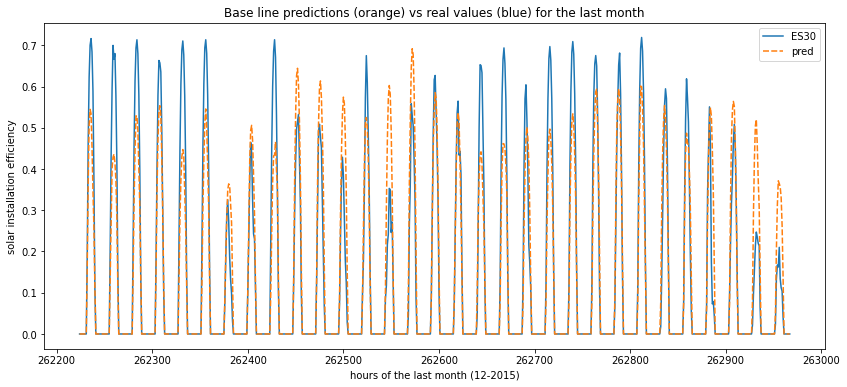

In [ ]:
def plot_predictions(data):
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=data)
    plt.title("Base line predictions (orange) vs real values (blue) for the last month")
    plt.xlabel("hours of the last month (12-2015)")
    plt.ylabel("solar installation efficiency")
    plt.show()

plot_predictions(data=x_test[['ES30', 'pred']])

In [ ]:
X_train, y_train = train_data[['month', 'week', 'day', 'hour']], train_data['ES30']
X_test, y_test = test_data[['month', 'week', 'day', 'hour']], test_data['ES30']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((86856, 4), (86856,), (744, 4), (744,))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgbm


def get_rmse(reg, model_name):
    """Print the score for the model passed in argument and retrun scores for the train/test sets"""
    
    y_train_pred, y_pred = reg.predict(X_train), reg.predict(X_test)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on Training  = {rmse_train:.2f} / RMSE on Test = {rmse_test:.2f}')
    
    return rmse_train, rmse_test


# list of all the basic models used at first
model_list = [
    LinearRegression(), Lasso(), Ridge(), ElasticNet(),
    RandomForestRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(),
    xgb.XGBRegressor(), lgbm.LGBMRegressor(), KNeighborsRegressor()
             ]

# creation of list of names and scores for the train / test
model_names.extend([str(m)[:str(m).index('(')] for m in model_list])


# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)

base_line 	 - RMSE on Training  = 0.27 / RMSE on Test = 0.23
LinearRegression 	 - RMSE on Training  = 0.27 / RMSE on Test = 0.23
Lasso 	 - RMSE on Training  = 0.27 / RMSE on Test = 0.23
Ridge 	 - RMSE on Training  = 0.27 / RMSE on Test = 0.23
ElasticNet 	 - RMSE on Training  = 0.09 / RMSE on Test = 0.10
RandomForestRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.08
GradientBoostingRegressor 	 - RMSE on Training  = 0.09 / RMSE on Test = 0.11
[04:52:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ExtraTreesRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.08
XGBRegressor 	 - RMSE on Training  = 0.09 / RMSE on Test = 0.08
LGBMRegressor 	 - RMSE on Training  = 0.09 / RMSE on Test = 0.09


In [ ]:
print("""
svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30
""")


svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30



In [ ]:
print("""
svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56
""")


svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


poly_lin_reg = Pipeline([
    ("poly_feat", PolynomialFeatures(degree=4)),
    ("linear_reg", LinearRegression())
])

poly_lin_reg.fit(X_train, y_train)

sc_train, sc_test = get_rmse(poly_lin_reg, "Poly Linear Reg")

model_names.append('Poly Linear Reg')
rmse_train.append(sc_train)
rmse_test.append(sc_test)

Poly Linear Reg 	 - RMSE on Training  = 0.13 / RMSE on Test = 0.13


In [ ]:
# train data for 10 years
train_data_d = df[-24*365*10:][['ES30', 'month', 'week', 'day', 'hour']]

# one hot encoding for categorical feature
cat_feat = ['month', 'week', 'day', 'hour']
train_data_d = pd.get_dummies(data=train_data_d, columns=cat_feat, drop_first=True)
train_data_d.head()

# keep last month for the test data set
test_data_d, train_data_d = train_data_d[-24*31:], train_data_d[:-24*31]

# get_dummies or one hot encoding
X_train_d, y_train_d = train_data_d.drop(columns=['ES30']), train_data_d['ES30']
X_test_d, y_test_d = test_data_d.drop(columns=['ES30']), test_data_d['ES30']

# verify if different shapes match
X_train_d.shape, y_train_d.shape, X_test_d.shape, y_test_d.shape

((86856, 450), (86856,), (744, 450), (744,))

In [ ]:
categorical_linreg = LinearRegression()
categorical_linreg.fit(X_train, y_train)
sc_train, sc_test = get_rmse(categorical_linreg, "Categorical lin. reg.")
print("Not more efficient than linear regression without get dummies")

Categorical lin. reg. 	 - RMSE on Training  = 0.27 / RMSE on Test = 0.23
Not more efficient than linear regression without get dummies


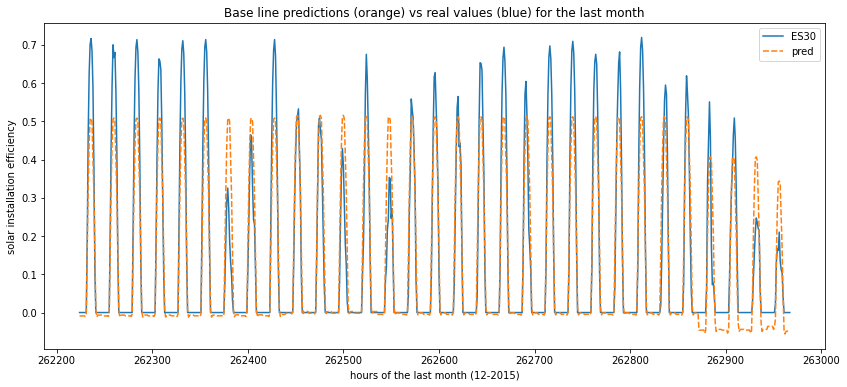

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = pd.DataFrame(gbr.predict(X_test))

y_test = pd.DataFrame(y_test)
y_test['pred'] = y_pred.values

plot_predictions(data=y_test)

In [ ]:
# reload the data
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/EMHIRES_SOLAR_PVGIS_TSh_CF_n2.xlsx")
df = add_date_time(df)
#df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]


# only keep what it usefull to use here
data = df[['time', 'ES30']]
data = data.rename(columns={"time": "ds", "ES30": "y"})

# train set : 10 yrs. except last month
train_data = data[-24*365*10:-24*31]

# test set = last month of the record (2015)
test_data = data[-24*31:]

In [ ]:
from fbprophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_data)
test_data.tail()
#y_train_pred = prophet_model.predict(train_data)

,ds,y
262963,2015-12-31 19:00:00,0.0
262964,2015-12-31 20:00:00,0.0
262965,2015-12-31 21:00:00,0.0
262966,2015-12-31 22:00:00,0.0
262967,2015-12-31 23:00:00,0.0


In [ ]:
forecast = prophet_model.predict(test_data)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['ES30'] = test_data['y'].values
forecast.tail()

,ds,yhat,yhat_lower,yhat_upper,ES30
739,2015-12-31 19:00:00,-0.077234,-0.219995,0.054207,0.0
740,2015-12-31 20:00:00,-0.071094,-0.203696,0.068703,0.0
741,2015-12-31 21:00:00,-0.054457,-0.194078,0.089518,0.0
742,2015-12-31 22:00:00,-0.053153,-0.194082,0.087610,0.0
743,2015-12-31 23:00:00,-0.066366,-0.201287,0.075337,0.0


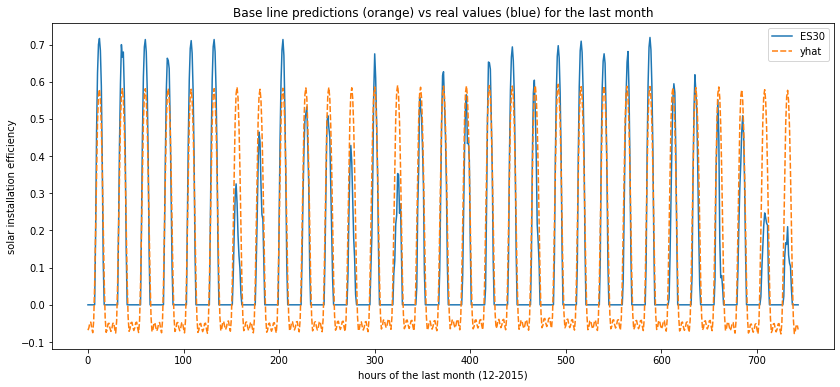

In [ ]:
model_names.append("prophet") #.extend(["prophet", "prophet_lower", "prophet_upper"])

rmse_train.append(0)
#rmse_train.extend([0, 0, 0])
rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_lower'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_upper'])))


plot_predictions(data=forecast[['ES30', 'yhat']])

# if we wanted to plot aslo inf / sup
# plt.figure(figsize=(18, 8))
# sns.lineplot(data=forecast[['ES30', 'yhat_lower', 'yhat_upper']])

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/EMHIRES_SOLAR_PVGIS_TSh_CF_n2.xlsx")
df = df[sorted([c for c in df.columns if 'ES' in c])]

# keep only 4 years
df = df[-24*365*4:]

# nb lines / cols
df.shape

(35040, 16)

In [ ]:
def process_data(data, past):
    X = []
    for i in range(len(data)-past-1):
        X.append(data.iloc[i:i+past].values)
    return np.array(X)


lookback = 48

y = df['ES30'][lookback+1:] 
X = process_data(df, lookback)
X.shape, y.shape

((34991, 48, 16), (34991,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27992, 48, 16), (6999, 48, 16), (27992,), (6999,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout


def my_RNN():
    my_rnn = Sequential()
    #my_rnn.add(SimpleRNN(units=32, return_sequences=True, input_shape=(lookback,22)))
    my_rnn.add(SimpleRNN(units=32, return_sequences=True, input_shape=(lookback,16)))
    my_rnn.add(SimpleRNN(units=32, return_sequences=True))
    my_rnn.add(SimpleRNN(units=32, return_sequences=False))
    my_rnn.add(Dense(units=1, activation='linear'))
    return my_rnn


rnn_model = my_RNN()
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
438/438 [==============================] - 17s 33ms/step - loss: 0.0191 - val_loss: 0.0076
Epoch 2/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 3/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 4/50
438/438 [==============================] - 18s 41ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 5/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 7/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 8/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/50
438/438 [==============================] - 14s 32ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
438/438 [==============================] - 14s 32ms/step - loss: 0.003

In [ ]:
y_pred_train, y_pred_test = rnn_model.predict(X_train), rnn_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.04493874944906234, 0.04760776760774273)

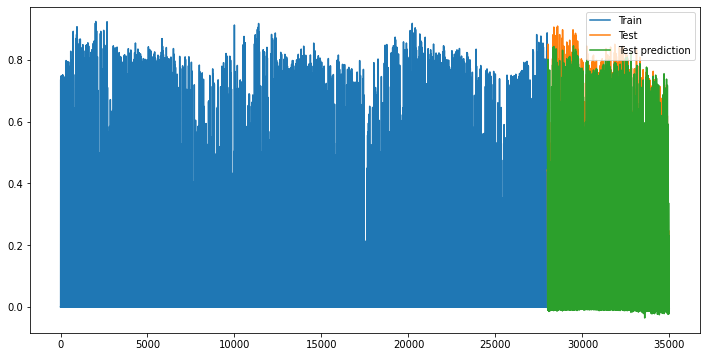

In [ ]:
def append_results(model_name):
    model_names.append(model_name)
    rmse_train.append(err_train)
    rmse_test.append(err_test)

append_results("RNN")


def plot_evolution():
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(X_train)), y_train, label='Train')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_test, label='Test')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_pred_test, label='Test prediction')
    plt.legend()
    plt.show()

plot_evolution()

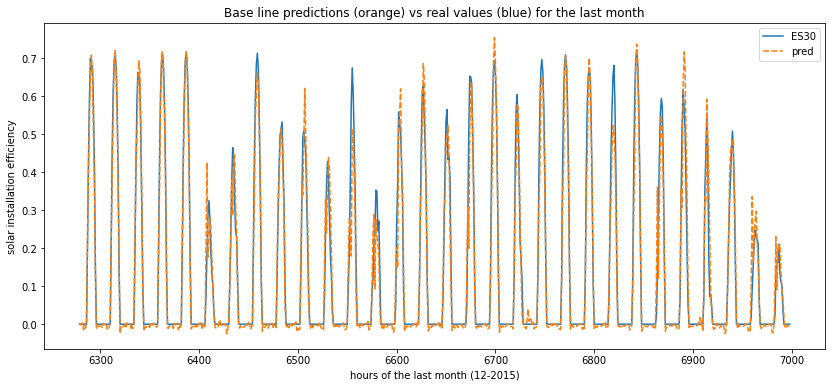

In [ ]:
rnn_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['ES30', 'pred'])
plot_predictions(data=rnn_res[-30*24:])

In [ ]:
from tensorflow.keras.layers import GRU

def my_GRU(input_shape):
    my_GRU = Sequential()
    my_GRU.add(GRU(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_GRU.add(GRU(units=32, activation='relu', return_sequences=False))
    my_GRU.add(Dense(units=1, activation='linear'))
    return my_GRU

gru_model = my_GRU(X.shape[1:])
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
875/875 [==============================] - 39s 42ms/step - loss: 0.0113 - val_loss: 0.0050
Epoch 2/50
875/875 [==============================] - 37s 43ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 3/50
875/875 [==============================] - 37s 42ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/50
875/875 [==============================] - 37s 42ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/50
875/875 [==============================] - 37s 42ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/50
875/875 [==============================] - 38s 43ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/50
875/875 [==============================] - 37s 42ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 8/50
875/875 [==============================] - 37s 43ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/50
875/875 [==============================] - 38s 43ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/50
875/875 [==============================] - 37s 43ms/step - loss: 0.002

In [ ]:
y_pred_train, y_pred_test = gru_model.predict(X_train), gru_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.044345529571602184, 0.052660988301785366)

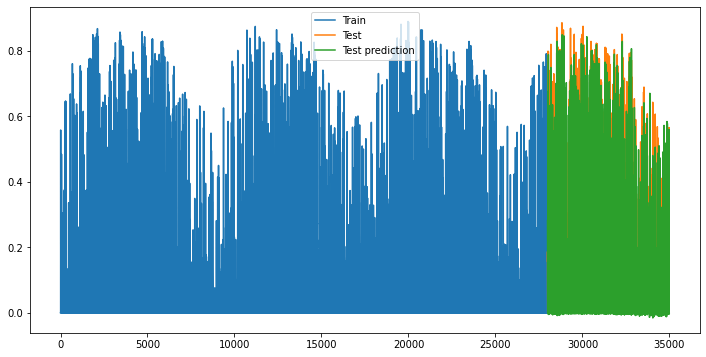

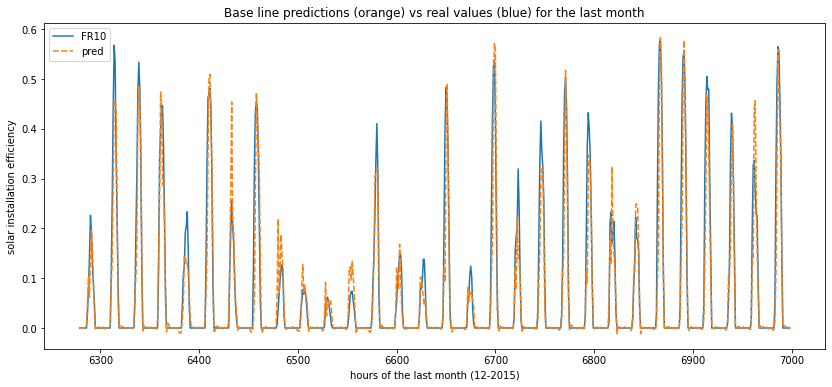

In [ ]:
append_results("GRU")
plot_evolution()

gru_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['ES30', 'pred'])
plot_predictions(data=gru_res[-30*24:])

In [ ]:
from tensorflow.keras.layers import LSTM

def my_LSTM(input_shape):
    my_LSTM = Sequential()
    my_LSTM.add(LSTM(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_LSTM.add(LSTM(units=32, activation='relu', return_sequences=False))
    my_LSTM.add(Dense(units=1, activation='linear'))
    return my_LSTM

lstm_model = my_LSTM(X.shape[1:])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
875/875 [==============================] - 36s 39ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 2/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 3/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 5/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/50
875/875 [==============================] - 34s 39ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 10/50
875/875 [==============================] - 34s 39ms/step - loss: 0.003

In [ ]:
y_pred_train, y_pred_test = lstm_model.predict(X_train), lstm_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.04632852028941903, 0.05339559144366762)

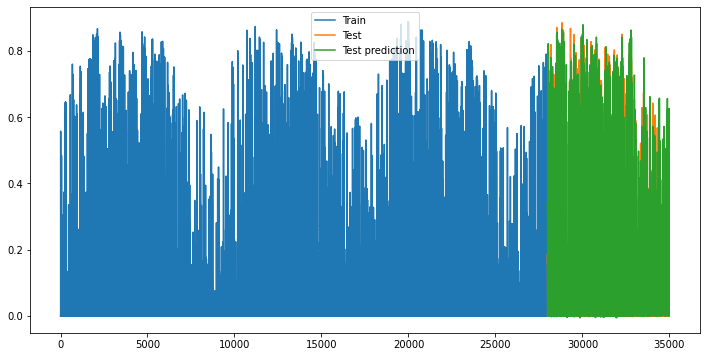

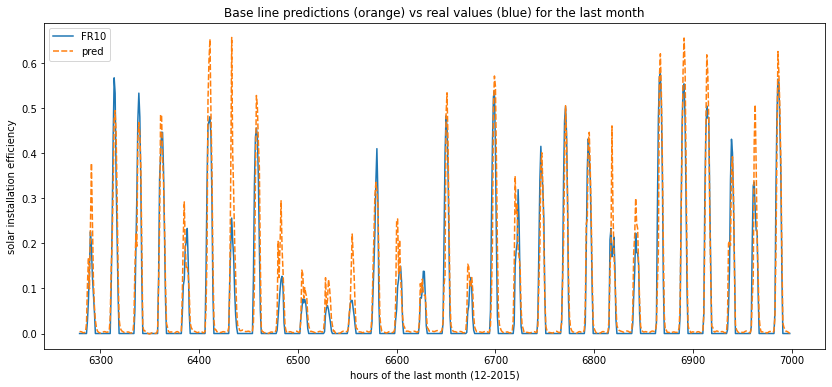

In [ ]:
append_results("LSTM")
plot_evolution()

lstm_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['ES30', 'pred'])
plot_predictions(data=lstm_res[-30*24:])

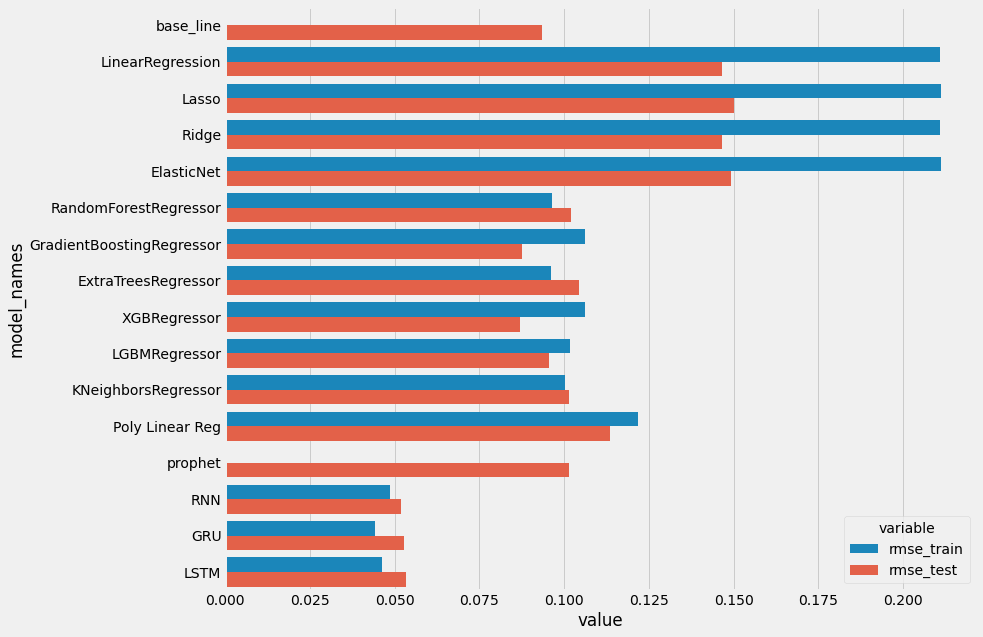

In [ ]:
#len(model_names), len(rmse_train), len(rmse_test)
plt.style.use('fivethirtyeight')
plot_scores()

**From this last graph we can conclude:**
*   The Linear Regression is underfitting and doesn't perform well.
*   Using the Polynomial feature allows us to get better results with no underfitting this time but this is not enough compared to the baseline.
*   Finally, the boosting family performs a little better but there isn't any real convincing difference compared to the baseline. It could have been interesting to tune hyperparameters with the RandomizedSearchCV or GridSearchCV methods, but I don't think we'll obtain a real gain.
*   The prophet is also not suited here. Those models perform well when it comes to getting an overall shape but aren't suited when there is a short-term change due to the weather on the global tendency. That's why deep learning models are better here. Nevertheless, it should be noted to the R.N.N uses the history of the past two days, this can also explain why the last 3 models are more performant. The same history can probably be used with other models in order to obtain better forecasts.


**From a general perspective:**
*   The RMSE is around 0.05 compared to values ranging from 0 to 1.
*   Anyway, it is necessary to relativize because most of the values are under 0.7 and it should be put into perspective that many values are nulls.
*   Finally, the RMSE with R.N.N is half the RMSE of the baseline which is quite optimistic.
*   It could be interesting to tune the parameters of a few models to see if we gain a few percent(next time).







